In [1]:
include("interpolation.jl")

spinterp

# Кусочно-линейная интерполяция

Что самое простое можно сделать с набором точек? Соединить отрезками. В этом и состоит кусочно-линейная интерполяция.

Математически: на каждом отрезке $[t_k, t_{k+1}]$ интерполянт является отрезком прямой, соединяющей точки $(t_k, y_k)$ и $(t_{k+1}, y_{k+1})$

```{math}
:label: pwlin

p(x) = y_k + \frac{y_{k+1} - y_k}{t_{k+1} - t_k} (x - t_k),\quad x \in [t_k, t_{k+1}]
```

Простой способ реализации формулы {eq}`pwlin` заключается в поиске отрезка $[t_k, t_{k+1}]$, которому принадлежит $x$, а затем уже в применении {eq}`pwlin`.

Мы же поступим более общим способом.

## Hat-функции

Искомый интерполянт лишь одна из *непрерывных кусочно-линейных* функций, которые образуют *линейное пространство*. В этом пространстве функция выражается в виде

```{math}
:label: pwlin_decomp

p(x) = \sum_{k=1}^n c_k \varphi_k(x),\quad x \in [t_1, t_n].
```

Где набор функций $\{\varphi_k(x)\}$ является *базисом* пространства, а коэффициенты (веса, координаты) $c_k$ однозначно задают $p(x)$. В качестве такого базиса широко используются hat-функции.

Hat-функция $\varphi_k$ это функция треугольного вида, задающаяся аналитически в виде

```{math}
:label: hatfunc

\varphi_k(x) = \begin{cases}
\dfrac{x-t_{k-1}}{t_k - t_{k-1}},& x \in [t_k, t_{k-1}],\\
\dfrac{t_{k+1}-x}{t_{k+1} - t_k},& x \in [t_{k+1}, t_k],\\
0, & иначе.
\end{cases},\quad k = 2,...,n-1
```

Мы здесь не будем специально выписывать формулы для $\varphi_1$ и $\varphi_n$, которые являются половинчатыми hat-функциями.

Реализуем hat-функции через замыкание.

:::{admonition} Функция : `hatfunc`
:class: note

**Hat-функция** $\varphi_k(x)$.

```julia
"""
Возращает hat-функцию φ_k(x) для отсортированной сетки абсцисс `t`.
Индекс `k ∈ [1, size(t, 1)]`.
"""
function hatfunc(t, k)
    n = size(t, 1)
    return function (x)
        if k ≥ 2 && t[k-1] ≤ x ≤ t[k]
            return (x - t[k-1]) / (t[k] - t[k-1])
        elseif k ≤ n-1 && t[k] ≤ x ≤ t[k+1]
            return (t[k+1] - x) / (t[k+1] - t[k])
        else  # x вне [t[1], t[end]] или неподходящий k
            return zero(x)
        end
    end
end
```
:::

Допустим, интерполяция производится по четырём точкам $t_1 = 1.0, t_2 = 1.3, t_3 = 3.1, t_4 = 4.0$ (абсциссы), соответствующий базис имеет вид.

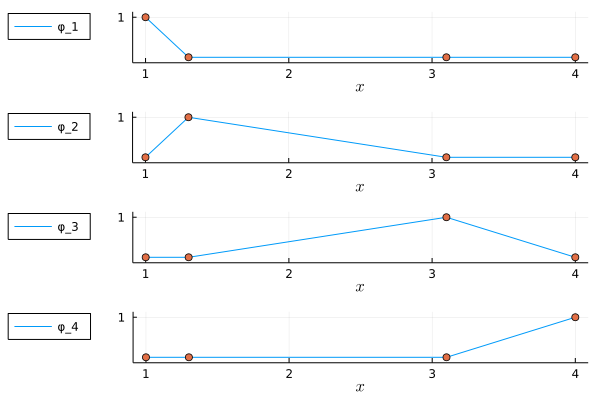

In [2]:
ts = [1.0, 1.3, 3.1, 4.0]
xs = range(first(ts), last(ts); length=200)
plt = plot(layout=(4,1),xlabel=L"x", ylims=[-0.1,1.1], ytick=[1], leg=:outertopleft)
for k in 1:size(ts, 1)
    φ_k = hatfunc(ts, k)
    plot!(xs, φ_k.(xs); label="φ_$k", subplot=k)
    scatter!(ts, φ_k.(ts); label="", subplot=k)
end
plt

## Интерполяция

Поскольку hat-функции обладают свойством

```{math}
:label: cardinality

\varphi_k(t_l) = \begin{cases}
1, & k = l,\\
0, & k \ne l.
\end{cases}
```

То коэффициенты $c_k$ в разложении {eq}`pwlin_decomp` равняются $y_k$

```{math}
p(x) = \sum_{k=1}^n y_k \varphi_k(x),\quad x \in [t_1, t_n].
```

Ниже реализация

:::{admonition} Функция : `pwlininterp(t, y)`
:class: note

**Кусочно-линейная интерполяция.**

```julia
"Возвращает кусочно-линейный интерполянт для точек (`t[i]`, `y[i]`)."
function pwlininterp(t, y)
    basis = [hatfunc(t, k) for k in 1:size(t, 1)]
    return x -> sum(y[k]*basis[k](x) for k in 1:size(y, 1))
end
```
:::

```{note} Пояснения по синтаксису
:class: dropdown

> `basis = [hatfunc(t, k) for k in 1:size(t, 1)]`

Создание вектора из функций с помощью [Array comprehensions](https://docs.julialang.org/en/v1/manual/arrays/#man-comprehensions).

> `sum(y[k]*basis[k](x) for k in 1:size(y, 1))`

- Внутри `sum` стоит [генератор](https://docs.julialang.org/en/v1/manual/arrays/#Generator-Expressions), что очень похоже на Array Comprehension, но не аллоцирует массив;
- `basis[k](x)` стоит читать как `(basis[k])(x)`: извлечение `k`-го элемента массива `basis`, что является функцией и затем вызов этой функции с аргументом `x`.
```

Рассмотрим пример кусочно-линейной интерполяции на функции из раздела {ref}`poly_equalspaced`.

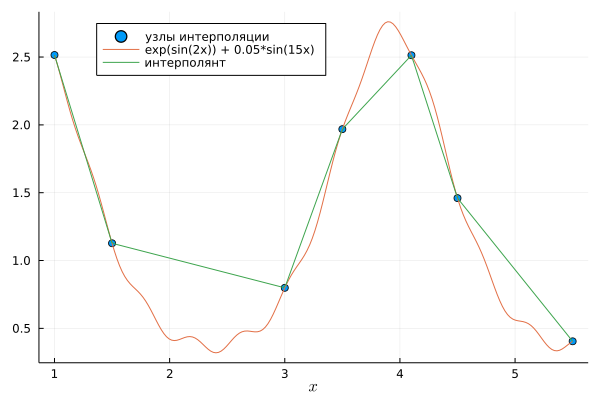

In [3]:
foo(x) = exp(sin(2x)) + 0.05*sin(15x)
ts = [1.0, 1.5, 3.0, 3.5, 4.1, 4.5, 5.5]
ys = foo.(ts)

interpolant = pwlininterp(ts, ys)

scatter(ts, ys; label="узлы интерполяции", legend=:top, xlabel=L"x")
xs = range(first(ts), last(ts); length=200)
plot!(xs, foo.(xs); label="exp(sin(2x)) + 0.05*sin(15x)")
plot!(xs, interpolant.(xs); label="интерполянт")

Возьмём большее число точек, на этот раз равноотстоящих.

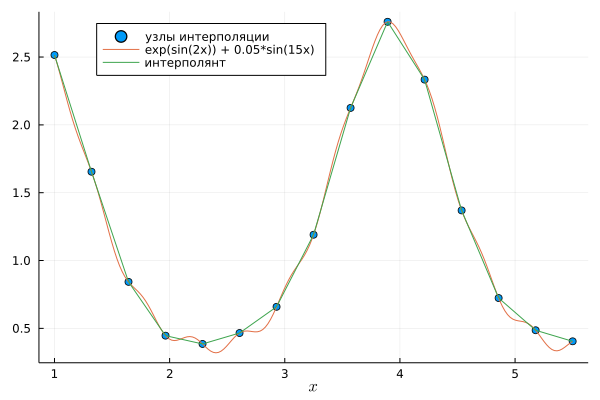

In [4]:
foo(x) = exp(sin(2x)) + 0.05*sin(15x)
ts = range(1.0, 5.5; length=15)
ys = foo.(ts)

interpolant = pwlininterp(ts, ys)

scatter(ts, ys; label="узлы интерполяции", legend=:top, xlabel=L"x")
xs = range(first(ts), last(ts); length=200)
plot!(xs, foo.(xs); label="exp(sin(2x)) + 0.05*sin(15x)")
plot!(xs, interpolant.(xs); label="интерполянт")

Похоже, интерполянт стремится к некоторому пределу...

## Сходимость

Можно рассмотреть, как меняется ошибка приближения функции интерполянтом в зависимости от количества использующихся точек. Нам понадобятся несколько инструментов.

Для измерения величины ошибки введём $\infty$-**норму функции**. Эта норма показывает насколько сильно отклоняется функция $f$ от нуля на отрезке $[a, b]$

```{math}
\|f\|_\infty = \max_{x\in[a,b]} |f(x)|.
```

Введём также *равномерную* **сетку** из узлов
```{math}
\omega_h = \{t_i\!: \: t_i = a + (i-1) h, \: h = (b-a)/n, \: i=1,...,n\},
```
где число $n$ называют **размером сетки**, а $h$ её **мелкостью** (или шагом).

Каждой сетке $\omega_h$ поставим в соответствие интерполянт $p_h(x)$ функции $f(x)$:

```{math}
p_h(t_i) = f(t_i), t_i \in \omega_h.
```

Теперь есть всё, чтобы представить утверждение.

```{admonition} Утверждение: сходимость кусочно-линейной интерполяции.
:class: note

Дважды непрерывно-дифференцируемую на $[a, b]$ функцию $f(x)$ кусочно-линейный интерполянт $p_h(x)$ приближает с оценкой

$$
\|f - p_h\|_\infty = \max_{x\in[a,b]}|f(x) - p_h(x)| \le M h^2,\quad M = \|f''\|_\infty.
$$
```

Из утверждения видно, что при уменьшении шага сетки $h \to 0$ ошибка интерполяции составляет $O(h^2)$.
Если ошибка приближения составляет $O(h^m)$ при $h \to 0$, то говорят о **сходимости** приближения с **порядком** $m$.

%%%Демонстрация

Ниже демонстрация сходимости на функции $f(x)=\exp(\sin(2x)) + 0.05\sin(15x)$.

Сгенерируем несколько равномерных сеток $\omega_h$, построим на них интерполянт и посчитаем норму ошибки. Тогда, поскольку $\|f - p_h \|_\infty \approx C h^2$, то 

```{math}
\log \|f - p_h \|_\infty \approx 2\cdot\log h + \log C.
```
А значит на графике зависимости ошибки от $h$ в log-log осях мы должны наблюдать прямую с наклоном 2.

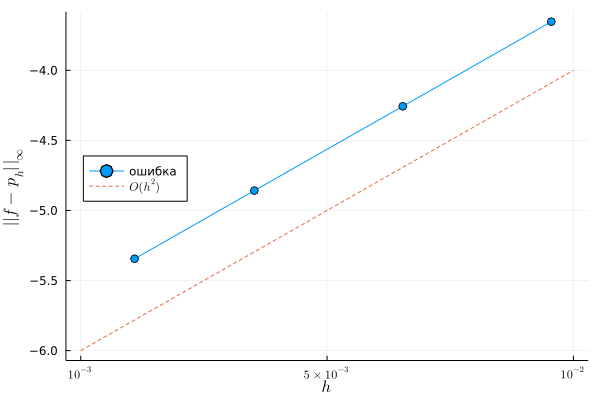

In [5]:
foo(x) = exp(sin(2x)) + 0.05*sin(15x)
a, b = (1, 5.5)
xs = range(a, b; length=10000)
mesh_h = []
err = []
for n in (500, 1000, 2000, 3500)
    ts = range(a, b; length=n)
    h = (b - a) / (n - 1)
    ys = foo.(ts)
    interpolant = pwlininterp(ts, ys)
    Δ = norm(foo.(xs) - interpolant.(xs), Inf)
    push!(mesh_h, h)
    push!(err, Δ)
end
plot(log10.(mesh_h), log10.(err);
    m=:o, label="ошибка", leg=:left, xlabel=L"h", ylabel=L"||f-p_h||_\infty" 
)
plot!([-3, -2], [-6, -4]; line=:dash, label=L"O(h^2)")
xticks!(
    [-3.0, -2.5, -2, -1.5],
    [L"10^{-3}", L"5\times10^{-3}", L"10^{-2}", L"5\times10^{-2}"]
)

%%%